In [2]:
import os
import ast
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [3]:
class EarlyStopper:
    def __init__(self, patience, tolerance):
        self.patience = patience
        self.tolerance = tolerance
        self.best_accuracy = float('-inf')
        self.epoch_counter = 0

    def should_stop(self, val_accuracy):
        if val_accuracy > self.best_accuracy + self.tolerance:
            self.best_accuracy = val_accuracy
            self.epoch_counter = 0
        else:
            self.epoch_counter += 1
            if self.epoch_counter >= self.patience:
                return True
        return False

In [4]:
import os

parent_directory = 'saved_models'


if not os.path.exists(parent_directory):
    
    os.makedirs(parent_directory)
    print(f"Parent directory '{parent_directory}' created successfully.")
else:
    print(f"Parent directory '{parent_directory}' already exists.")


sentiment_analysis_file_path = os.path.join(parent_directory, 'sentiment_analysis.py')


test_sentiment_analysis_file_path = os.path.join(parent_directory, 'test_sentiment_analysis.py')

senti_file_path = os.path.join(parent_directory, 'test_sentiment_analysis.py')

Untitled16_file_path = os.path.join(parent_directory, 'Untitled16')


if not os.path.exists(test_sentiment_analysis_file_path):

    
    print(f"File '{test_sentiment_analysis_file_path}' created successfully.")
else:
    print(f"File '{test_sentiment_analysis_file_path}' already exists.")

Parent directory 'saved_models' already exists.
File 'saved_models/test_sentiment_analysis.py' already exists.


In [5]:
class SentimentAnalysisModel(nn.Module):
    def __init__(self, embedding_dim, output_dim, pretrained_embeddings):
        super(SentimentAnalysisModel, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        
        self.conv1 = nn.Conv1d(embedding_dim, 256, kernel_size=3, padding=1)
        self.adaptive_pool1 = nn.AdaptiveMaxPool1d(output_size=25)
        
        self.conv2 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.adaptive_pool2 = nn.AdaptiveMaxPool1d(output_size=10)
        
        self.fc1 = nn.Linear(128 * 10, 512)
        self.fc2 = nn.Linear(512, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.adaptive_pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool2(x)
        
        x = x.view(-1, 128 * 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    torch.save(model.state_dict(), save_path)

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, text_data, labels, word_to_index, max_len=50):
        self.text_data = text_data
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_len = max_len

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        label = self.labels[idx]

        numerical_text = [self.word_to_index.get(word, 0) for word in text.split()]
        numerical_text = torch.tensor(numerical_text, dtype=torch.long)

        
        padded_text = torch.zeros(self.max_len, dtype=torch.long)
        padded_text[:len(numerical_text)] = numerical_text[:self.max_len]

        return padded_text, torch.tensor(label, dtype=torch.float)

In [9]:
filepath = "/transfer/katie/glove.6B.50d.txt"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


word_to_index = {}
pretrained_embeddings = []
with open(filepath) as embeddings_file:
    for idx, line in enumerate(embeddings_file):
        values = line.split()
        word = values[0]
        embedding = [float(value) for value in values[1:]]
        word_to_index[word] = idx
        pretrained_embeddings.append(embedding)


pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32).to(DEVICE)
encoding = 'ISO-8859-1'
dataset_path = 'training.1600000.processed.noemoticon.csv'
df = pd.read_csv(os.path.expanduser(dataset_path), encoding=encoding, header=None)
df_shuffled = df.sample(frac=1).reset_index(drop=True)

text_data = df_shuffled.iloc[:, 5].tolist()
sentiment_labels = df_shuffled.iloc[:, 0].tolist()


train_texts, test_texts, train_labels, test_labels = train_test_split(
    text_data, sentiment_labels, test_size=0.2, random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42
)

train_dataset = SentimentDataset(train_texts, train_labels, word_to_index)
val_dataset = SentimentDataset(val_texts, val_labels, word_to_index)
test_dataset = SentimentDataset(test_texts, test_labels, word_to_index)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

log_dir = "logs"
writer = SummaryWriter(log_dir=log_dir)

def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = f"{save_dir}/{filename}"
    torch.save(model.state_dict(), save_path)

Using device: cuda


In [10]:
batch_size = 1024
epochs = 20
embedding_dim = 50  
output_dim = 1
model = SentimentAnalysisModel(embedding_dim, output_dim, pretrained_embeddings)

criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.00001) 

train_dataset = SentimentDataset(train_texts, train_labels, word_to_index)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

early_stopper = EarlyStopper(patience=3, tolerance=0.001)


In [11]:
train_texts[:10]

['As if diversity won!!! I was rooting for susan boyle...love her!!! ',
 "Up so early this morning, and asleep so late! Curse this heat! Just made a mistake on a custom order that I'll now have to re-do ",
 "Yeah, surprise second set from Pandora's Box who were great yesterday  Mozzy Green not so hot, should play some major chords sometimes...",
 'Ok....stepping away from my phone for a lil bit. Peace! ',
 '@Adjectiveless From the looks of things, no. ',
 'Boreeed ',
 "It's raining pretty good here at the moment.  That might kill another trip to the Arboretuem ",
 'is afk. Will eat daily dose of chocolate but will workout afterwards. Tata.  http://plurk.com/p/vfa18',
 '@ElspethMurray and these pink merry-go-rounds are candelabra primulas.  aptly named indeed.  Looks like you had fun ',
 "Almost finished with new moon.... If I didn't have to work tomorrow I would totally finish it tonight! Geez... "]

In [12]:
train_labels[:10]

[0, 0, 1, 1, 0, 1, 0, 1, 1, 0]

In [13]:
early_stopper = EarlyStopper(patience=5, tolerance=0.001)
def train_model_gpu(model, epochs, train_loader, optimizer, criterion):
    model = model.to(DEVICE)
    msg = ""
    for epoch in range(epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        model.train()
        for batch_num, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            batch_msg = f'Train minibatch [{batch_num+1}/{len(train_loader)}]'
            print(batch_msg, end='\r' if batch_num < len(train_loader) else "\n", flush=True)

        epoch_loss = total_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_predictions

        print(" " * len(msg), end='\r') 
        msg = f'\nTrain Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.5f}, Accuracy: {epoch_accuracy:.5f}'
        print(msg)

In [14]:
train_model_gpu(model, epochs, train_loader, optimizer, criterion)

Train minibatch [1125/1125]
Train Epoch [1/20], Loss: 0.69489, Accuracy: 0.50019
                                                     
Train Epoch [2/20], Loss: 0.69481, Accuracy: 0.50019
                                                     
Train Epoch [3/20], Loss: 0.69473, Accuracy: 0.50019
                                                     
Train Epoch [4/20], Loss: 0.69465, Accuracy: 0.50019
                                                     
Train Epoch [5/20], Loss: 0.69458, Accuracy: 0.50019
                                                     
Train Epoch [6/20], Loss: 0.69451, Accuracy: 0.50019
                                                     
Train Epoch [7/20], Loss: 0.69445, Accuracy: 0.50019
                                                     
Train Epoch [8/20], Loss: 0.69439, Accuracy: 0.50019
                                                     
Train Epoch [9/20], Loss: 0.69433, Accuracy: 0.50019
                                                     
Train Epo

In [15]:
def train_model_final(model, 
                      epochs, 
                      dataloaders, 
                      optimizer, 
                      lr_scheduler, 
                      writer, 
                      early_stopper, 
                      checkpoint_frequency):
    msg = ""
    for epoch in range(epochs):        
        #######################TRAINING STEP###################################
        model.train()  # set model to training mode 
        train_dl = dataloaders['train'] # select train dataloader
        
        total_steps_train = len(train_dl)
        correct_train = 0
        total_train = 0
        loss_train = 0
        
        for batch_num, (text_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(text_batch)
            label_batch = label_batch.to(DEVICE)
            text_batch = text_batch.to(DEVICE)  
            output = model(text_batch)
            loss_train = nn.BCELoss()(output.squeeze(), label_batch)
                        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            preds_train = (output > 0.5).float()
            correct_train += int((preds_train == label_batch).sum())
            total_train += batch_sz
            minibatch_accuracy_train = 100 * correct_train / total_train
            
            
            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_train}], Loss: {loss_train.item():.5f}, Acc: {minibatch_accuracy_train:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)
            
        lr_scheduler.step()      
        print("") 
        #######################VALIDATION STEP##################################
        model.eval()  
        val_dl = dataloaders['val'] #


        total_steps_val = len(val_dl)
        correct_val = 0
        total_val = 0
        loss_val = 0
        
        for batch_num, (text_batch, label_batch) in enumerate(val_dl):
            batch_sz = len(text_batch)
            label_batch = label_batch.to(DEVICE)
            text_batch = text_batch.to(DEVICE)  
            
            with torch.no_grad(): 
                output = model(text_batch)
                loss_val = nn.BCELoss()(output.squeeze(), label_batch)

                preds_val = (output > 0.5).float()  
                correct_val += int((preds_val == label_batch).sum())
                total_val += batch_sz
                minibatch_accuracy_val = 100 * correct_val / total_val
                if (batch_num + 1) % 5 == 0:
                    print(" " * len(msg), end='\r')
                    msg = f'Eval epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_val}], Loss: {loss_val.item():.5f}, Acc: {minibatch_accuracy_val:.5f}'
                    if early_stopper.epoch_counter > 0:
                        msg += f", Epochs without improvement: {early_stopper.epoch_counter}"
                    print (msg, end='\r' if epoch < epochs else "\n",flush=True)
                
        print("")  
        
         
        epoch_train_acc = 100 * correct_train / total_train
        epoch_val_acc = 100 * correct_val / total_val

        writer.add_scalar('Loss/train', loss_train, epoch)
        writer.add_scalar('Loss/val', loss_val, epoch)
        writer.add_scalar('Acc/train', epoch_train_acc, epoch)
        writer.add_scalar('Acc/val', epoch_val_acc, epoch)

        
        if epoch % checkpoint_frequency == 0:        
            save_checkpoint(model, epoch, "./saved_models")  

        
        if early_stopper.should_stop(epoch_val_acc):
            print(f"\nValidation accuracy has not improved in {early_stopper.epoch_counter} epochs, stopping.")
           
            save_checkpoint(model, epoch, "./saved_models")
            return

                

In [16]:
import os
import torch

def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pt"
    save_path = os.path.join(save_dir, filename)
    
    # Check if the directory exists
    if not os.path.exists(save_dir):
        print(f"Error: Directory '{save_dir}' does not exist.")
        return

    try:
        torch.save(model.state_dict(), save_path)
        print(f"Model checkpoint saved at '{save_path}'.")
    except Exception as e:
        print(f"Error occurred while saving checkpoint: {e}")

In [17]:
epochs = 15               
batch_size = 1024         
checkpoint_frequency = 3   

dataloaders = {
    'train': train_loader,  
    'val': val_loader,      
    'test': test_loader    
}


model = SentimentAnalysisModel(embedding_dim, output_dim, pretrained_embeddings)

optimizer = optim.SGD(model.parameters(), lr=0.00001)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

model = model.to(DEVICE)


train_model_final(model, epochs, dataloaders, optimizer, lr_scheduler, writer, early_stopper, checkpoint_frequency)


Train epoch[1/15], MiniBatch[1125/1125], Loss: 0.69285, Acc: 51219.85590, LR: 0.00001
Eval epoch[1/15], MiniBatch[125/125], Loss: 0.69349, Acc: 51148.55156                
Model checkpoint saved at './saved_models/checkpoint_0.pt'.
Train epoch[2/15], MiniBatch[1125/1125], Loss: 0.69228, Acc: 51219.89774, LR: 0.00000
Eval epoch[2/15], MiniBatch[125/125], Loss: 0.69349, Acc: 51148.57969                
Train epoch[3/15], MiniBatch[1125/1125], Loss: 0.69304, Acc: 51219.90156, LR: 0.00000
Eval epoch[3/15], MiniBatch[125/125], Loss: 0.69349, Acc: 51148.57969                
Train epoch[4/15], MiniBatch[1125/1125], Loss: 0.69325, Acc: 51219.84931, LR: 0.00000
Eval epoch[4/15], MiniBatch[125/125], Loss: 0.69349, Acc: 51148.57969, Epochs without improvement: 1
Model checkpoint saved at './saved_models/checkpoint_3.pt'.
Train epoch[5/15], MiniBatch[1125/1125], Loss: 0.69290, Acc: 51219.82674, LR: 0.00000               
Eval epoch[5/15], MiniBatch[125/125], Loss: 0.69349, Acc: 51148.57969, Epoch

In [18]:
last_epoch = 5
loaded_net_state_dict = torch.load(f'./saved_models/checkpoint_6.pt')

In [19]:
def test_sentiment_model(model, dataloaders):
    model.eval()
    correct = 0
    total = 0
    
    test_dl = dataloaders['test']
    total_steps = len(test_dl)
    msg = ""
    for batch_num, (text_batch, label_batch) in enumerate(test_dl):
        batch_sz = len(text_batch)
        label_batch = label_batch.to(DEVICE)
        text_batch = text_batch.to(DEVICE)
        with torch.no_grad():
            outputs = model(text_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == label_batch).sum().item()
        total += label_batch.size(0)
        if (batch_num + 1) % 5 == 0:
            print(" " * len(msg), end='\r')
            msg = f'Testing batch[{batch_num + 1}/{total_steps}]'
            print (msg, end='\r' if batch_num < total_steps else "\n", flush=True)
    print(f"\nFinal test accuracy for {total} examples: {100 * correct / total:.5f}%")

In [20]:
test_sentiment_model(model, dataloaders)

Testing batch[310/313]
Final test accuracy for 320000 examples: 49.95031%


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.1/785.1 kB 10.2 MB/s eta 0:00:00m eta 0:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords') 
#nltk.download('stopwords'): Downloads NLTK stopwords, which are commonly used words (e.g., "the," "is," "and") 
#that are often removed from text data during text processing for tasks like sentiment analysis or classification.
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 



from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder


import re # Regular expressions are useful for pattern matching and text manipulation.

print("Tensorflow Version", tf.__version__)

Tensorflow Version 2.15.0


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/s5313889/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1167810369,Mon Apr 06 22:19:15 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1167810672,Mon Apr 06 22:19:19 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1167810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1167811181,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1167811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [30]:
df.columns = ['sentiment','text']
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [31]:
lab_to_sentiment = {0:"Negative", 1:"Positive"}
# convert numerical labels into human-readable categorical labels, making the data more understandable
def label_decoder(label):
    return lab_to_sentiment[label]
df['sentiment'] = df['sentiment'].map(label_decoder)
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

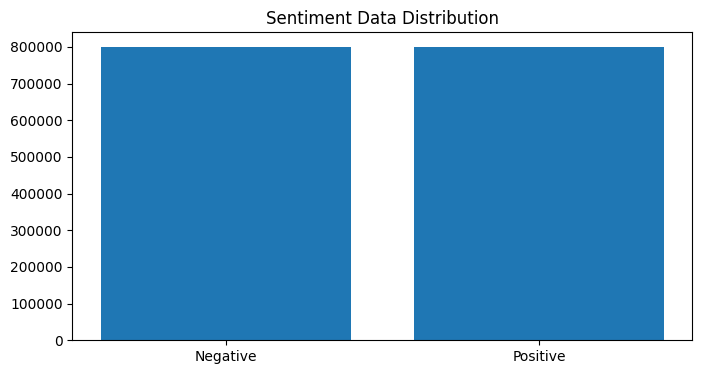

In [32]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [33]:
df.sample(n=10)

,sentiment,text
252747,Negative,dang brandy you've always been skinny but DANG...
943006,Positive,has a rather exciting announcement to...er..an...
525801,Negative,Ever felt like unrequited obsessive love was s...
1270089,Positive,@egregson Oh 2 Bodies is such a classic. I ho...
1461096,Positive,Video How To For A Great Plugin - Adds Subscri...
1214920,Positive,"Had an amazingly gorgeous sunny BBQ yesterday,..."
775703,Negative,I'm sooooooo off tomorrow....and I'm soooooo s...
1402955,Positive,is going to rub n' tug tonight. and not in a g...
1570028,Positive,@BBRRIITTTTYY yeah thats what i reckon
1369201,Positive,"@iLoveNickJ1LIFE Yeah, we're filming music vid..."


In [34]:
stop_words = stopwords.words('english') # (e.g., "the," "is," "and") that are often removed from text data
stemmer = SnowballStemmer('english') #"running" and "ran" would be stemmed to "run".

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"  # URL and username

In [35]:
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    #Any pattern matched by text_cleaning_re will be replaced with a single space ' '
    #.strip() removes leading and trailing whitespace characters (spaces, tabs, etc.) from the modified text.
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)  #Joins the filtered tokens back together using " "

In [36]:
df['text'] = df['text'].map(preprocess)

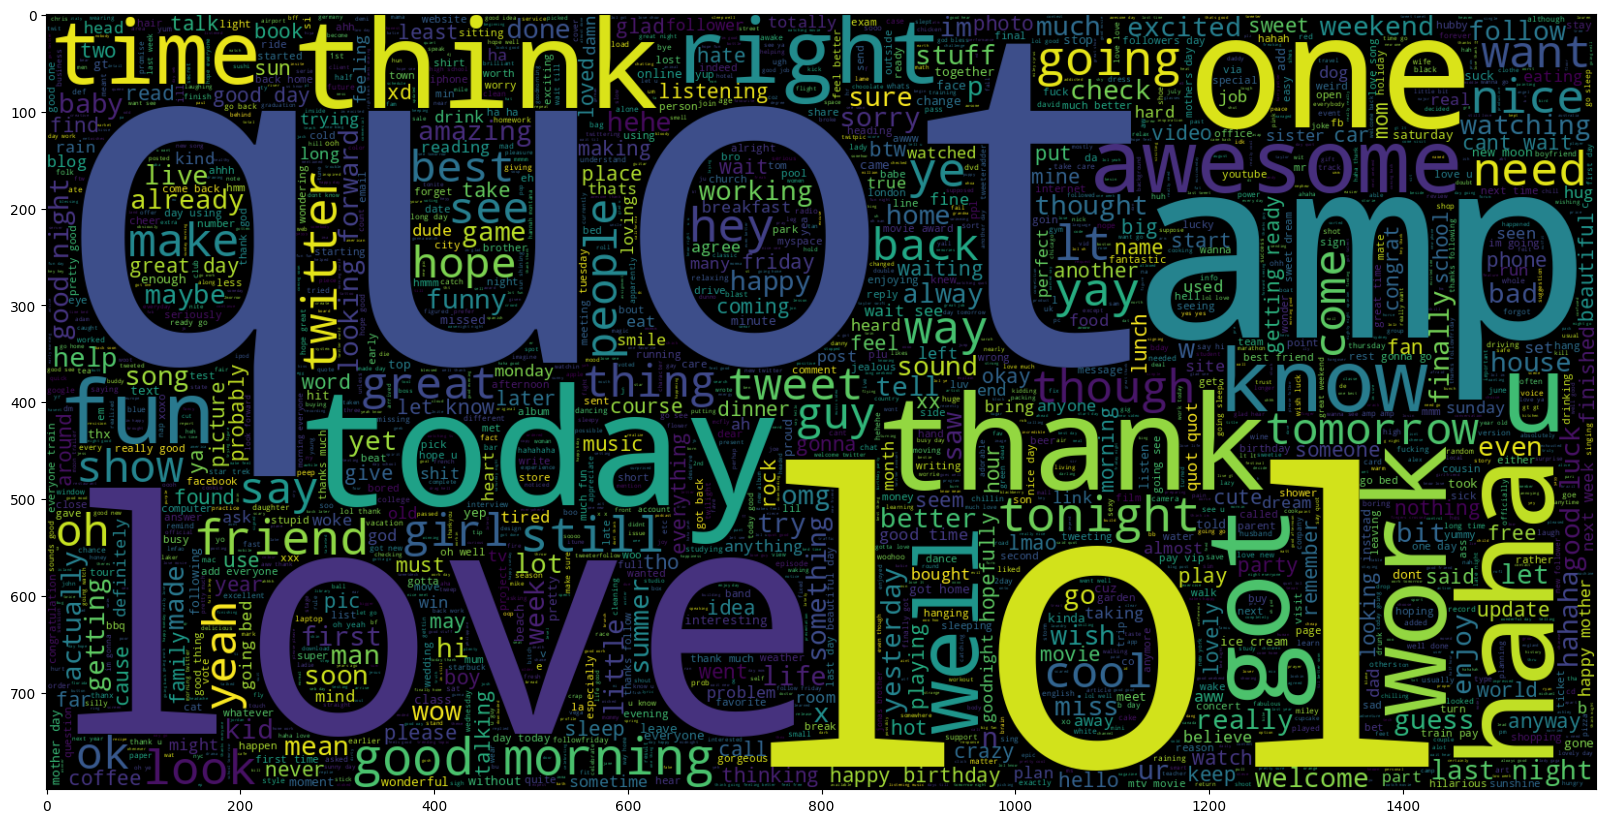

In [37]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

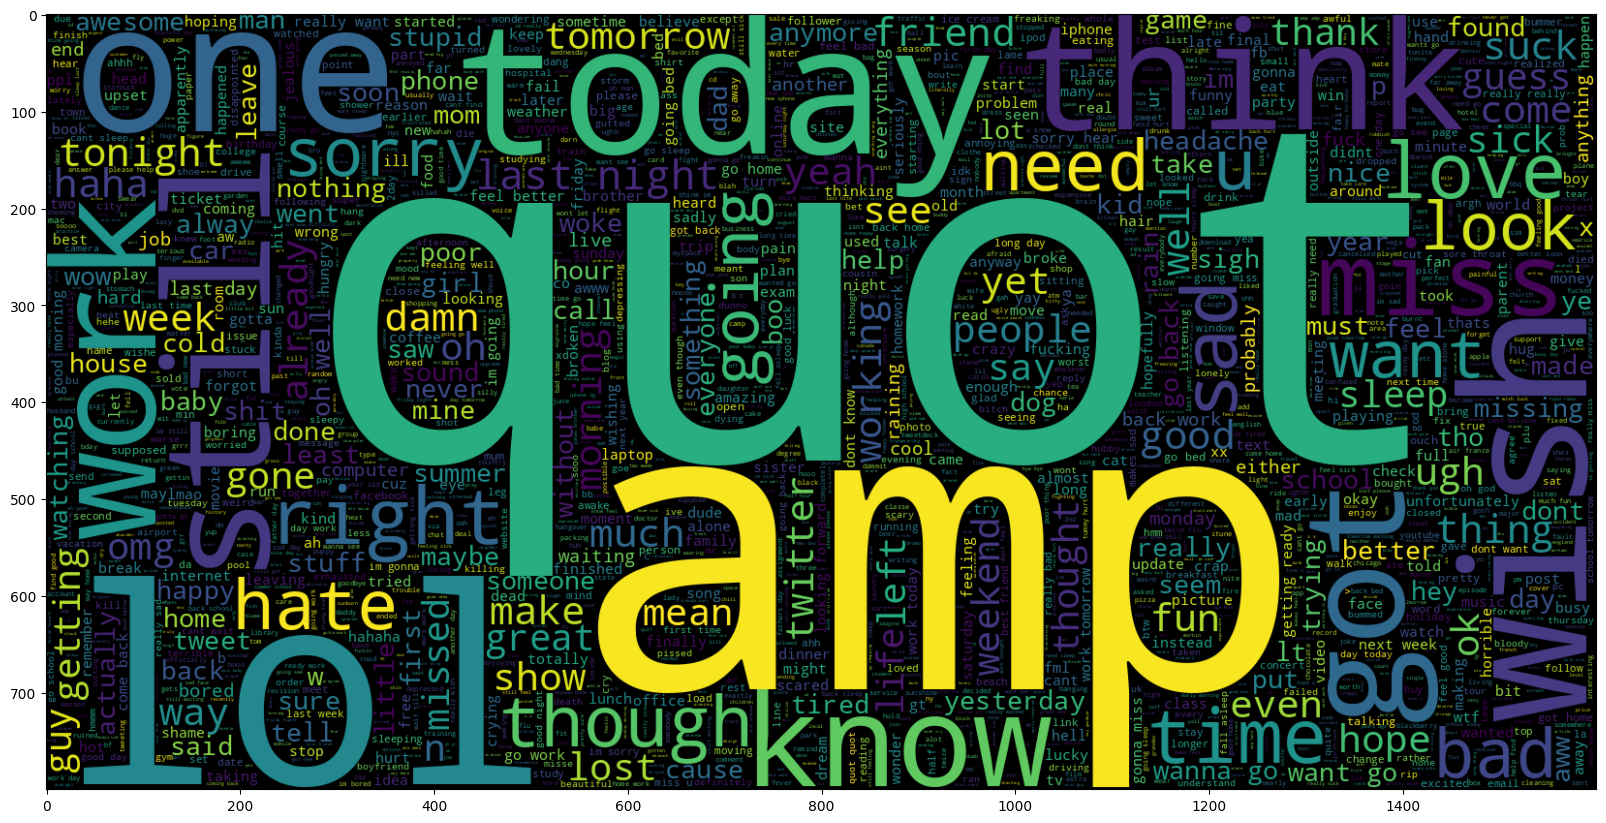

In [38]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')